## Introduction
I am fascinated by all the generative models but the sound they generate seems too artificial and I always wanted to make a clone of my voice. That would be a fun project but also would be a component of my Capstone- video generation.
The goal for this series of Assignmentt is to develop a pipeline that can classify, understand, and eventually mimic my voice. This work is structured into three key phases, each building on the previous one to achieve a highly personalized generative voice model.  

1. **Voice Classification**: The first step is to develop a binary classification system capable of distinguishing between my voice and others, as well as identifying whether the spoken language is English or not.

2. **Sentiment Analysis**: Once classification is established, the next step is to analyze the sentiment behind the speech. This involves detecting emotions such as happiness, sadness, or neutrality, allowing the model to capture not just *what* is being said, but *how* it is being expressed. I would try experimenting with some existing Generative models here.

3. **Generative Voice Model**: The final stage focuses on creating a system that can replicate my voice and speech patterns. By fine-tuning a pre-trained generative model with my own voice data, the goal is to synthesize natural-sounding speech that reflects my tone and sentiment. I will also add a LLM in the pipeline so people can talk to me and teh LLM can respnd directly.

Once this pipeline is complete, I will add this to my generated video to make vocational training materials for people in Nepal.

## Assignment 1: Audio Classification: Speaker & Language

This notebook does the following:
1. Use a single **metadata CSV** to label both **speaker** and **language**.
2. Extract **MFCC features** from each audio file.
3. Perform **binary classification** separately for:
   - **Speaker** (Jeevan vs. Not_Jeevan)
   - **Language** (English vs. Not_English)
4. Use **k-Fold Cross-Validation** to evaluate performance (accuracy, precision, recall, F1) and generate confusion matrices.

In [6]:
#Importing ALl libraries
import os
import pandas as pd
import librosa
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, precision_score, recall_score,
                             f1_score, auc, accuracy_score)
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tkinter as tk
import pyaudio
import wave
import joblib  # Import joblib to save and load models
import seaborn as sns
import warnings

# Data Collection
I collected data from the following sources:

* Youtube
* Google Photos Videos
* Facebook and Messenger Videos
* Recorded data via Apple's voice Memo to balance Data

# Data Pre Processing
* As seen above, most of my data is video. So, I used ffmpeg to convert all video files to audio. See code in my Github here: https://github.com/lifee77/voice-classification/blob/main/video_to_audio.py
* Used yt_dlp to download just the audio from youtube videos (These videos contain just my speech). No copyright infriengement intended. The channel used is in the codecell. See code here: https://github.com/lifee77/voice-classification/blob/main/youtube_to_audio.py
* Used librosa, ffmpeg to convert audio filetypes to mp3,normalize audio, trim audio data into equal slices of 7 seconds, removed silence, and added empty voice when a segment would be less than 7 seconds. See code here: https://github.com/lifee77/voice-classification/blob/main/audio_preprocessing.py

### Messy Data:
These factors might result in some inaccuracy.
* The audio is recorded from a phone, often with a lot of wind or people in the background. So, there's some noise that needs to be cleaned.
* Some data is labeled as one class but has data from both classes. 
    * In conversations when both people are speaking in one segment, I classified it based on whoever is speaking for a longer time duration. 
    * People who speak Nepali also sprinkle English words in between, again I used the majority time rule to label data.

# Data Labeling
The most challenging part after fining the data was labeling. I created a file metadata.csv (https://github.com/lifee77/voice-classification/blob/main/data/metadata.csv) with 3 columns; filename, speaker_label, and language_label. This is easier than keeping them in a separate folders. Google docs' find and replace was of tremendous help to label data. 
I used a script (https://github.com/lifee77/voice-classification/blob/main/automate_metadata.py) to ease metadata creation using csv. Otehrwise, I would have to type 800+ long filenames manually.

# Data Analysis

###  Initial Distribution: 
My first phase of data was unbalanced. Not surprisingly I had more voice of myself talking than other people. The initial data looked as below:

<img src = "initial_data_distribution.png">
Total Files: 561

Counts by Speaker:
  speaker_label  count
0        Jeevan    418
1    Not_Jeevan    143

Counts by Language:
  language_label  count
0    Not_English    350
1        English    211


This data would get an accuracy of 74.5% to predict Jeevan even when the model is not working. To remove this bias, I collected more data, and did the same pre-processing steps and got the following nearly symmetrical distribution.

Total Files: 823

Counts by Speaker:
  speaker_label  count
0        Jeevan    418
1    Not_Jeevan    405

Counts by Language:
  language_label  count
0    Not_English    434
1        English    389


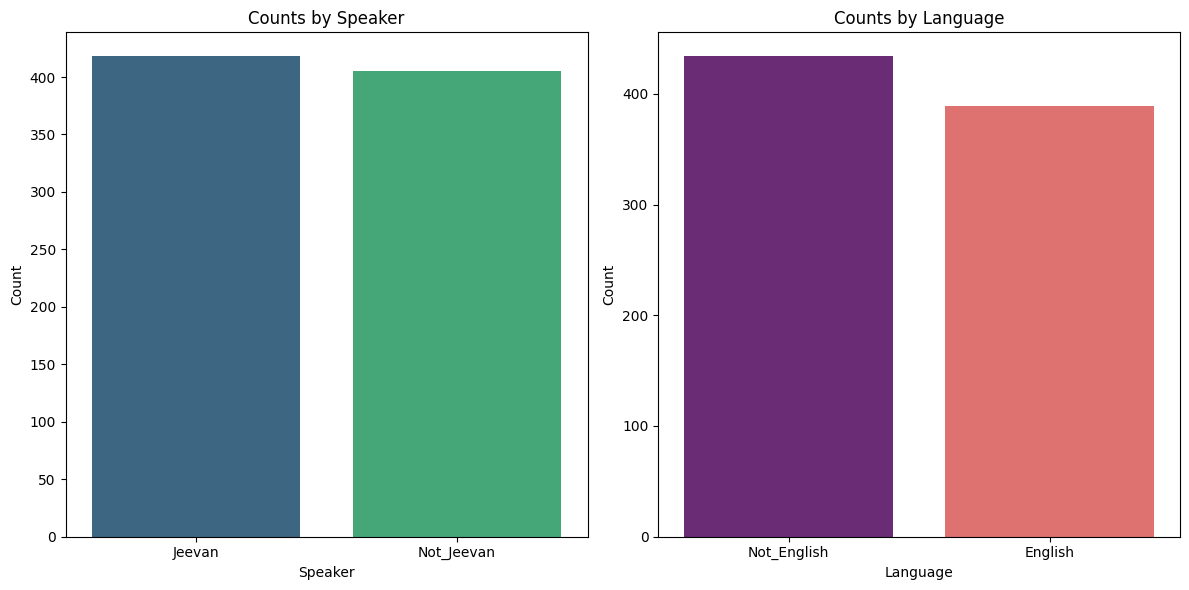

In [7]:
# Suppress FutureWarnings from seaborn (or other libraries)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the CSV file, which already has a header row
df = pd.read_csv('data/metadata.csv') 

# Total data statistics
total_files = len(df)
print("Total Files:", total_files)

# Statistics by speaker
speaker_counts = df['speaker_label'].value_counts().reset_index()
speaker_counts.columns = ['speaker_label', 'count']
print("\nCounts by Speaker:")
print(speaker_counts)

# Statistics by language
language_counts = df['language_label'].value_counts().reset_index()
language_counts.columns = ['language_label', 'count']
print("\nCounts by Language:")
print(language_counts)

# Visualization: Bar plots for speaker and language counts
plt.figure(figsize=(12, 6))

# Bar plot for speaker counts
plt.subplot(1, 2, 1)
sns.barplot(data=speaker_counts, x='speaker_label', y='count', palette="viridis")
plt.title("Counts by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")

# Bar plot for language counts
plt.subplot(1, 2, 2)
sns.barplot(data=language_counts, x='language_label', y='count', palette="magma")
plt.title("Counts by Language")
plt.xlabel("Language")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


This is not entirely symmetrical but both categories are close to 50% (49.21/ 50.79 and 47.27/52.73 splits for left and right graoh respectively).

## Feature extraction (explanation below)

In [8]:
def extract_features(file_path, sr=16000, n_mfcc=13):
    """
    Loads the audio file, extracts MFCC features, and returns the averaged MFCCs.
    """
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

In [10]:
def build_dataset(metadata_csv, audio_dir):
    """
    Reads metadata from a CSV that has at least 3 columns:
        - filename
        - speaker_label (e.g., "Jeevan" or "Not_Jeevan")
        - language_label (e.g., "English" or "Not_English")
    
    For each row:
      - Extracts MFCC features from the audio file.
      - Creates a binary label for speaker (1 for "Jeevan", 0 for others).
      - Creates a binary label for language (1 for "English", 0 for others).
    
    Returns:
      - X: Array of MFCC feature vectors.
      - y_speaker: Array of binary labels for speaker classification.
      - y_language: Array of binary labels for language classification.
    """
    df = pd.read_csv(metadata_csv)
    X, y_speaker, y_language = [], [], []
    for _, row in df.iterrows():
        file_path = os.path.join(audio_dir, row['filename'])
        features = extract_features(file_path)
        X.append(features)
        y_speaker.append(1 if row['speaker_label'].lower() == 'jeevan' else 0)
        y_language.append(1 if row['language_label'].lower() == 'english' else 0)
    return np.array(X), np.array(y_speaker), np.array(y_language)

def evaluate_classifier(X, y, clf, n_splits=5):
    """
    Performs k-Fold cross-validation using the specified classifier.
    
    Parameters:
      - X: Feature array.
      - y: True labels.
      - clf: A classifier instance.
      - n_splits: Number of folds for cross-validation.
    
    Returns:
      - report: A classification report as a string.
      - cm: The confusion matrix as a NumPy array.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X, y, cv=skf)
    report = classification_report(y, y_pred, target_names=["Class 0", "Class 1"])
    cm = confusion_matrix(y, y_pred)
    return report, cm
from sklearn.model_selection import StratifiedKFold, cross_val_score

def run_multiple_classifiers(X, y, classifiers, model_path, n_splits=5):
    """
    Evaluates multiple classifiers using K-fold cross-validation, selects the best model,
    and saves it to a file.

    Parameters:
      - X: Feature array.
      - y: Labels.
      - classifiers: Dictionary of classifiers (name: classifier instance).
      - model_path: Path to save the best model.
      - n_splits: Number of cross-validation folds.

    Returns:
      - results: A dictionary mapping classifier names to their evaluation results.
      - best_model: The best trained classifier.
    """
    results = {}
    best_model = None
    best_score = 0.0  # Track highest accuracy

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        print(f"Evaluating {name}...")
        
        # Compute cross-validation accuracy
        scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
        avg_score = scores.mean()
        
        # Train classifier on the full dataset
        clf.fit(X, y)

        # Store results
        report, cm = evaluate_classifier(X, y, clf, n_splits)
        results[name] = {"accuracy": avg_score, "report": report, "confusion_matrix": cm}

        print(f"{name} Accuracy: {avg_score:.4f}")

        # Save the best model based on accuracy
        if avg_score > best_score:
            best_score = avg_score
            best_model = clf

    # Save the best model
    joblib.dump(best_model, model_path)
    print(f" Best model ({best_model.__class__.__name__}) saved to {model_path}!")

    return results, best_model

def plot_confusion_matrix(cm, title):
    """
    Plots the confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


### Building the dataset

In [11]:
# Evaluate classifiers for Speaker Classification

# Paths to metadata CSV and audio files folder
metadata_csv_path = "data/metadata.csv"
audio_directory = "data/audio_data"

# Build dataset
X, y_speaker, y_language = build_dataset(metadata_csv_path, audio_directory)

#Visualizing the Data
print("X shape:", X.shape)
print("y_speaker shape:", y_speaker.shape)
print("y_language shape:", y_language.shape)


X shape: (823, 13)
y_speaker shape: (823,)
y_language shape: (823,)


#### Feature Extraction 
The audio data has 13 features that we are considering.

y_speaker.shape and y_language.shape both return (n_samples,) because there is one speaker/language label per audio file.


For feature extraction, I used the librosa library.
https://librosa.org/doc/main/feature.html#

1. Loads audio as a time-series waveform 'y' resampled to 16kHz 
2. Computes MFCCs (Mel-frequency cepstral coefficients) through:
    - Short-Time Fourier Transform (STFT) to get a spectrogram
    - Mel-frequency scaling (128-band filterbank by default) to mimic human hearing
    - Discrete Cosine Transform (DCT) to decorrelate Mel energies and compress to `n_mfcc=13` coefficients
3. Averages each of the 13 MFCCs over time (axis=1) to create a compact spectral signature
    
I read a few online sources including this one (https://dsp.stackexchange.com/questions/64430/how-to-train-and-test-deep-neural-network-using-mfcc-features). Seems like (n_mfcc=13) is standard for speech/music analysis. The first coefficient represents overall spectral energy, while subsequent coefficients capture increasingly fine spectral details.
Higher DCT coefficients (beyond ~20) often represent noise-sensitive details, making 13 a practical
compromise between information retention and dimensionality reduction. Considering my audio has too much background noise, I choose a number on the lower end of the spectrum.

In [7]:
# Define models
# I will use these three models using Scikit-learn library and test which one has the highest accuracy. Based on the results, 
#I might try to manually implement one of those.
classifiers = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}

# Paths to save the best models. We will use these at the end for testing.
speaker_model_path = "best_speaker_model.pkl"
language_model_path = "best_language_model.pkl"

# Train, evaluate, and save the best **Speaker Model**
print("\n### Speaker Classification ###")
speaker_results, best_speaker_model = run_multiple_classifiers(X, y_speaker, classifiers, speaker_model_path)

# Train, evaluate, and save the best **Language Model**
print("\n### Language Classification ###")
language_results, best_language_model = run_multiple_classifiers(X, y_language, classifiers, language_model_path)



### Speaker Classification ###
Evaluating SVM...
SVM Accuracy: 0.8591
Evaluating RandomForest...
RandomForest Accuracy: 0.9526
Evaluating LogisticRegression...
LogisticRegression Accuracy: 0.8445
 Best model (RandomForestClassifier) saved to best_speaker_model.pkl!

### Language Classification ###
Evaluating SVM...
SVM Accuracy: 0.8907
Evaluating RandomForest...
RandomForest Accuracy: 0.9514
Evaluating LogisticRegression...
LogisticRegression Accuracy: 0.8810
 Best model (RandomForestClassifier) saved to best_language_model.pkl!


# XGBoost

In [14]:
# XGBoost model for audio classification
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def build_xgboost_model(X_train, y_train):
    """
    Builds and trains an XGBoost model with hyperparameter tuning
    
    Parameters:
        X_train: Training features
        y_train: Training labels
    
    Returns:
        The trained XGBoost model
    """
    # Create preprocessing and model pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=42
        ))
    ])
    
    # Define hyperparameters for grid search
    param_grid = {
        'xgb__n_estimators': [50, 100, 200],
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.1, 0.2],
        'xgb__subsample': [0.8, 1.0],
        'xgb__colsample_bytree': [0.8, 1.0]
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, 
        scoring='accuracy', verbose=1, n_jobs=-1
    )
    
    # Train the model
    print("Training XGBoost model...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return best_model

In [15]:
# Use in your workflow
xgb_model_speaker = build_xgboost_model(X, y_speaker) 
xgb_model_language = build_xgboost_model(X, y_language)


Training XGBoost model...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Best cross-validation score: 0.7548
Training XGBoost model...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}
Best cross-validation score: 0.8348


# Got a lower cross-validation score: 0.7548

In [43]:
# Classification Reports
print("### Detailed Classification Reports for Speaker Classification ###")
for name, res in speaker_results.items():
    print(f"\nClassifier: {name}")
    print(res["report"])
    print("Confusion Matrix:")
    print(res["confusion_matrix"])
    
print("\n### Detailed Classification Reports for Language Classification ###")
for name, res in language_results.items():
    print(f"\nClassifier: {name}")
    print(res["report"])
    print("Confusion Matrix:")
    print(res["confusion_matrix"])


### Detailed Classification Reports for Speaker Classification ###

Classifier: SVM
              precision    recall  f1-score   support

     Class 0       0.86      0.86      0.86       405
     Class 1       0.86      0.86      0.86       418

    accuracy                           0.86       823
   macro avg       0.86      0.86      0.86       823
weighted avg       0.86      0.86      0.86       823

Confusion Matrix:
[[347  58]
 [ 58 360]]

Classifier: RandomForest
              precision    recall  f1-score   support

     Class 0       0.96      0.95      0.95       405
     Class 1       0.95      0.96      0.95       418

    accuracy                           0.95       823
   macro avg       0.95      0.95      0.95       823
weighted avg       0.95      0.95      0.95       823

Confusion Matrix:
[[384  21]
 [ 18 400]]

Classifier: LogisticRegression
              precision    recall  f1-score   support

     Class 0       0.84      0.84      0.84       405
     Class 1 

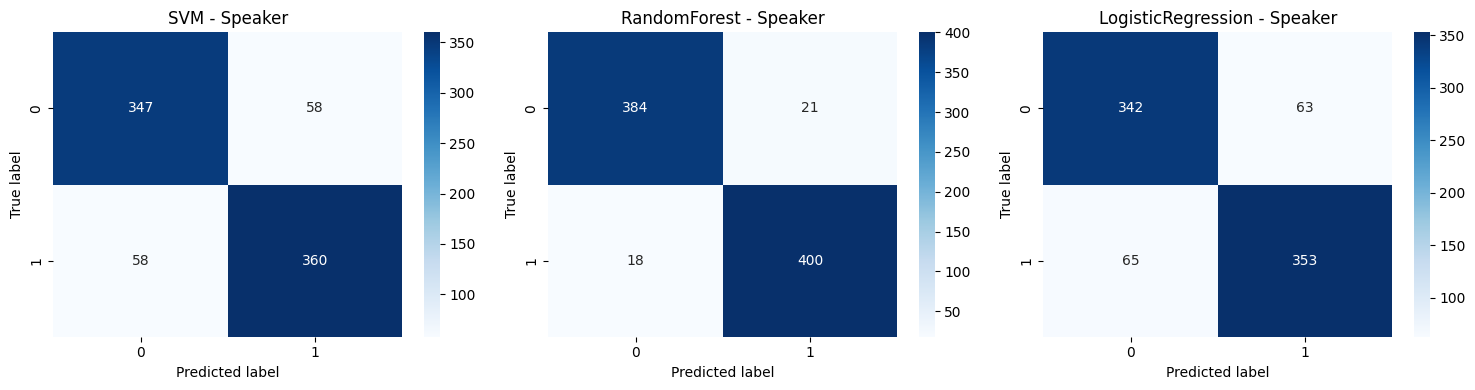

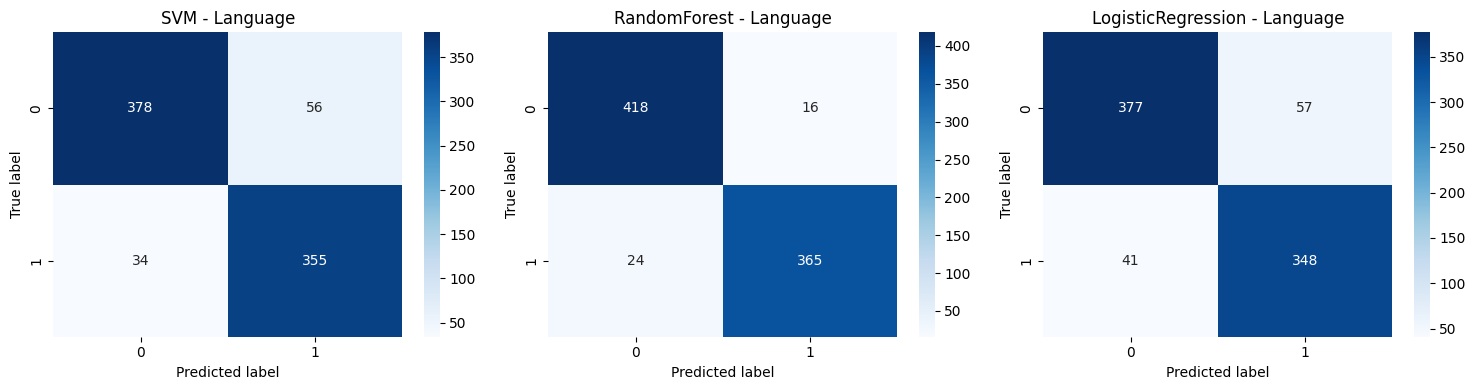

In [44]:
# Confusion Matrices for all Classification Types

def visualize_results(results, label_type):
    """
    Plots confusion matrices for each classifier.
    """
    num_classifiers = len(results)
    fig, axes = plt.subplots(1, num_classifiers, figsize=(5 * num_classifiers, 4))
    if num_classifiers == 1:
        axes = [axes]
    for ax, (name, res) in zip(axes, results.items()):
        cm = res['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f"{name} - {label_type}")
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Visualize confusion matrices for Speaker Classification
visualize_results(speaker_results, 'Speaker')

# Visualize confusion matrices for Language Classification
visualize_results(language_results, 'Language')

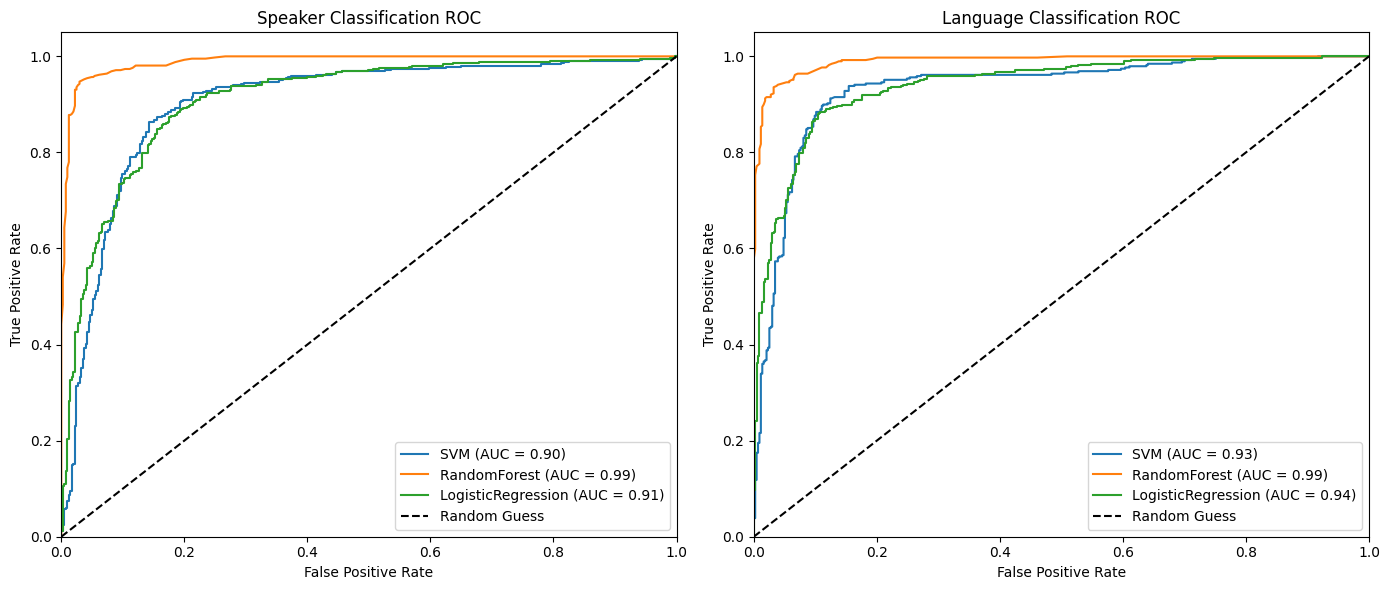

In [45]:
def plot_side_by_side_roc(X_speaker, y_speaker, X_language, y_language, classifiers):
    """
    Plots ROC curves side by side for Speaker and Language classification.

    Parameters:
      - X_speaker, y_speaker : Feature matrix & labels for speaker classification.
      - X_language, y_language : Feature matrix & labels for language classification.
      - classifiers : Dictionary of classifiers (name: classifier instance).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Two side-by-side plots
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Plot ROC for Speaker Classification
    ax = axes[0]
    ax.set_title("Speaker Classification ROC")
    for name, clf in classifiers.items():
        y_proba = cross_val_predict(clf, X_speaker, y_speaker, cv=skf, method="predict_proba")[:, 1]
        fpr, tpr, _ = roc_curve(y_speaker, y_proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    # Plot ROC for Language Classification
    ax = axes[1]
    ax.set_title("Language Classification ROC")
    for name, clf in classifiers.items():
        y_proba = cross_val_predict(clf, X_language, y_language, cv=skf, method="predict_proba")[:, 1]
        fpr, tpr, _ = roc_curve(y_language, y_proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function to plot Speaker and Language ROC curves side by side
plot_side_by_side_roc(X, y_speaker, X, y_language, classifiers)

### Comparing different Metrics

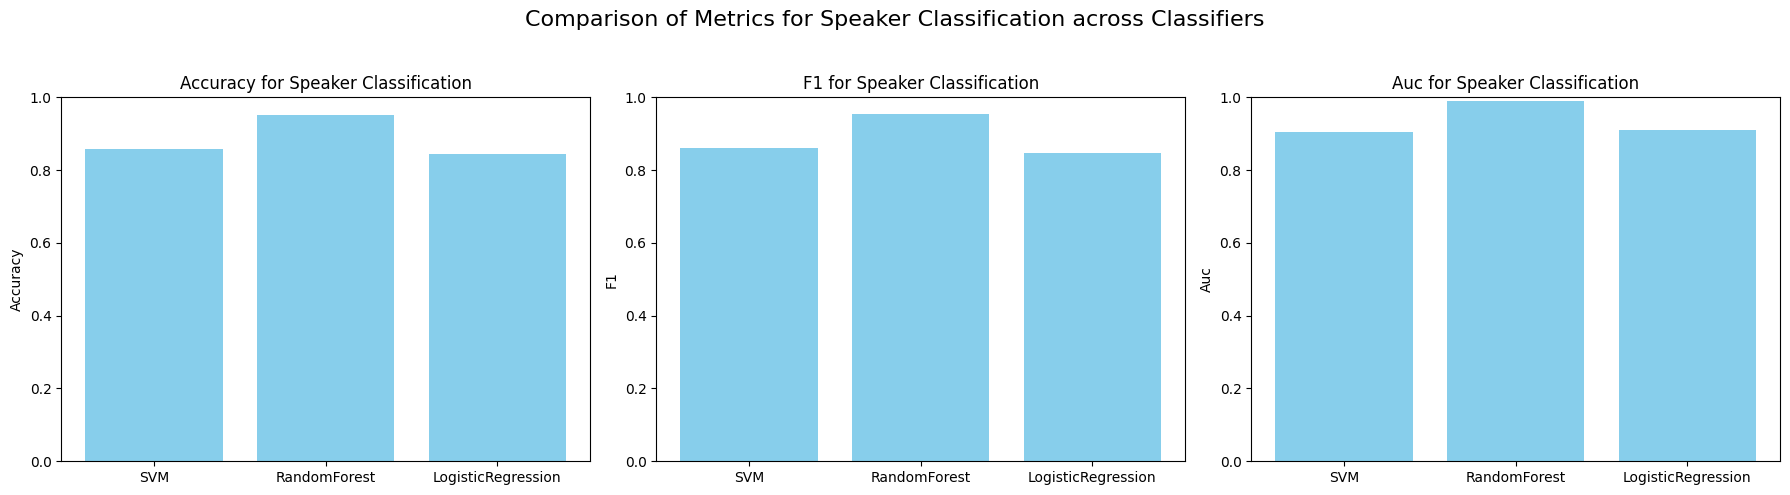

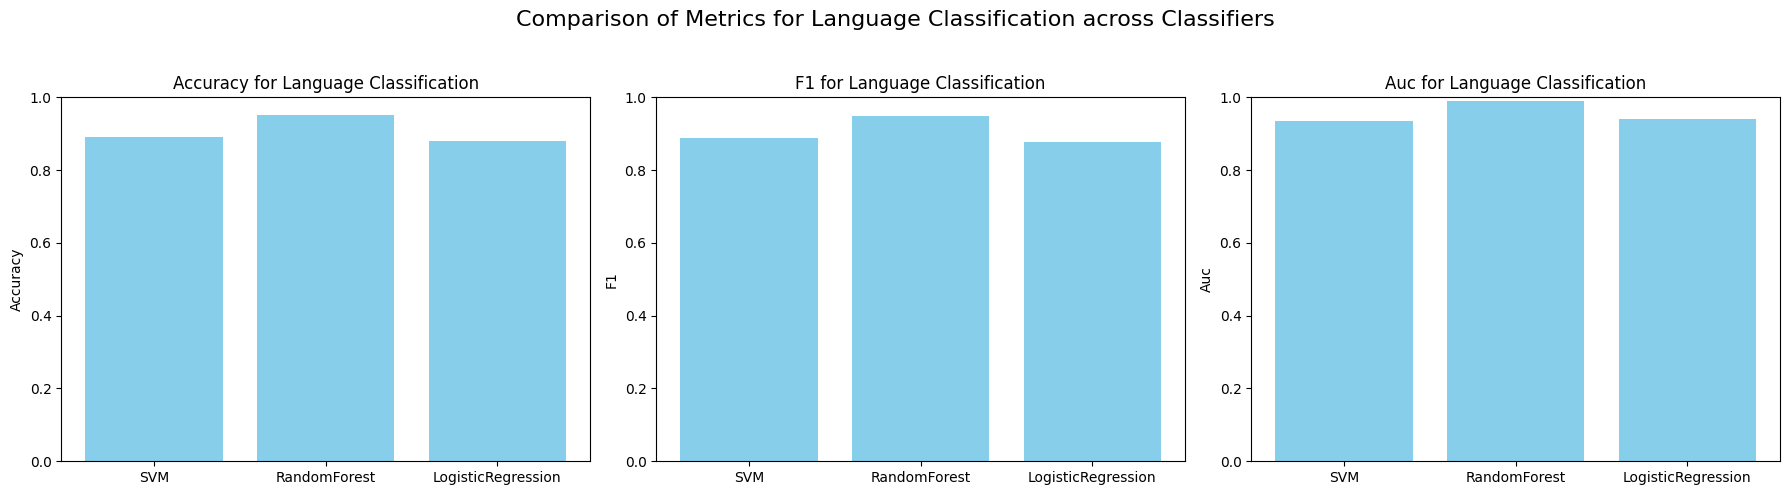

In [46]:
def compare_metrics_bar_plots(X, y, classifiers, label_type=""):
    """
    Evaluates each classifier using 5-fold cross-validation and displays side-by-side bar plots 
    for the following metrics:
      - Accuracy
      - F1 Score
      - AUC
    
    Parameters:
      X : numpy array of shape (m, n)
          Feature matrix.
      y : numpy array of shape (m,)
          Binary labels.
      classifiers : dict
          Dictionary of classifiers (name: classifier instance).
      label_type : str
          A string indicating the type of label (e.g., "Speaker" or "Language")
          for use in plot titles.
    """
    metrics_names = ['accuracy', 'f1', 'auc']
    results = {metric: {} for metric in metrics_names}
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, clf in classifiers.items():
        # Get predicted labels for accuracy and F1
        y_pred = cross_val_predict(clf, X, y, cv=skf)
        acc = accuracy_score(y, y_pred)
        f1_val = f1_score(y, y_pred)
        results['accuracy'][name] = acc
        results['f1'][name] = f1_val
        
        # Get predicted probabilities for AUC
        y_proba = cross_val_predict(clf, X, y, cv=skf, method="predict_proba")[:, 1]
        auc_val = roc_auc_score(y, y_proba)
        results['auc'][name] = auc_val

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(metrics_names):
        ax = axes[i]
        ax.bar(results[metric].keys(), results[metric].values(), color='skyblue')
        ax.set_ylim([0, 1])
        ax.set_title(f"{metric.capitalize()} for {label_type} Classification")
        ax.set_ylabel(metric.capitalize())
    fig.suptitle(f"Comparison of Metrics for {label_type} Classification across Classifiers", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

#Speaker classification:
compare_metrics_bar_plots(X, y_speaker, classifiers, label_type="Speaker")

#Language classification:
compare_metrics_bar_plots(X, y_language, classifiers, label_type="Language")

### Random Forest is doing the best across all metrics and labels.
It has a better accuracy, F1 and AUC for both labels as seen in the above two figures. Hence, this is the best model (There might be more suitable models though. I will experiment with those later in Assignment 2.)

####  Visualizing Audio Data
Because these feature vectors are high-dimensional (13 dimensions), we will reduce them to 2 dimensions for visualization. We will use Principal Component Analysis (PCA) to do so.

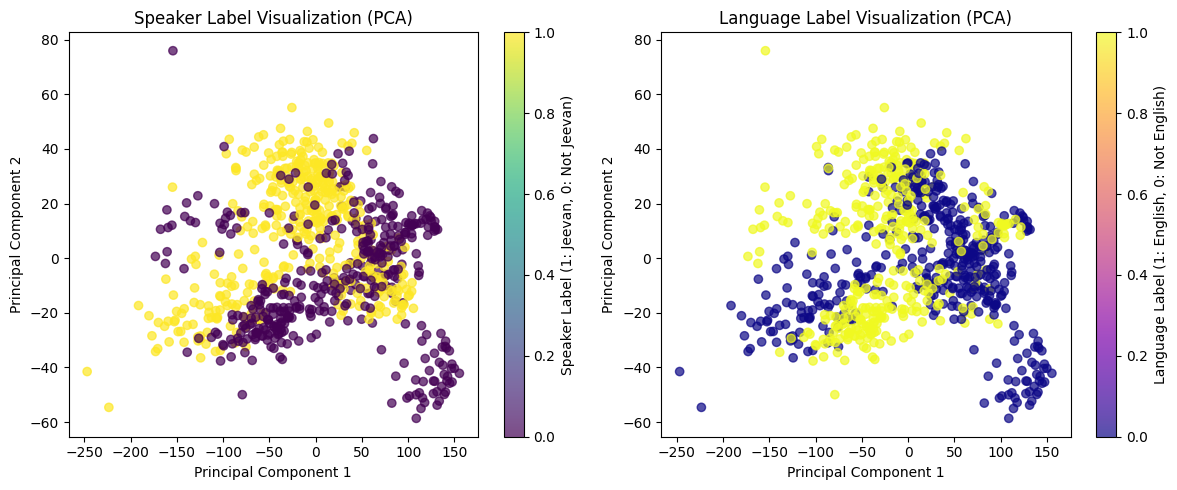

In [47]:
def plot_pca_scatter(X, y1, y2, n_components=2, comp_x=0, comp_y=1, figsize=(12, 5),
                     title1="Speaker Label Visualization (PCA)",
                     title2="Language Label Visualization (PCA)",
                     label1="Speaker Label (1: Jeevan, 0: Not Jeevan)",
                     label2="Language Label (1: English, 0: Not English)",
                     cmap1='viridis', cmap2='plasma', alpha=0.7):
    """
    Reduces the features in X using PCA and creates two scatter plots:
    - The first plot visualizes the data points colored by y1.
    - The second plot visualizes the data points colored by y2.
    
    Parameters:
      X : numpy array of shape [n_samples, n_features]
      y1 : numpy array (first set of labels)
      y2 : numpy array (second set of labels)
      n_components : int, default=2, the number of PCA components to compute
      comp_x : int, default=0, index of the PCA component to plot on the x-axis
      comp_y : int, default=1, index of the PCA component to plot on the y-axis
      ... (other parameters as before)
    """
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(X_reduced[:, comp_x], X_reduced[:, comp_y], c=y1, cmap=cmap1, alpha=alpha)
    plt.xlabel(f"Principal Component {comp_x+1}")
    plt.ylabel(f"Principal Component {comp_y+1}")
    plt.title(title1)
    plt.colorbar(scatter1, label=label1)
    
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(X_reduced[:, comp_x], X_reduced[:, comp_y], c=y2, cmap=cmap2, alpha=alpha)
    plt.xlabel(f"Principal Component {comp_x+1}")
    plt.ylabel(f"Principal Component {comp_y+1}")
    plt.title(title2)
    plt.colorbar(scatter2, label=label2)
    
    plt.tight_layout()
    plt.show()

#Choose the number of components and the two components to plot here.
plot_pca_scatter(X, y_speaker, y_language, n_components=3, comp_x=0, comp_y=1)

## Training a Model without Library (Logistic Regression)
While it is best to train a Random Forest, it is complicated because of all the decision trees. Hence, we will train a Logistic Regression without using a library, except for `numpy`.

### Mathematical Explanation

Goal: predicting whether the speaker is Jeevan or Not_Jeevan and whether the language is English or Not_English. Each audio file is represented by a feature vector of 13 dimensions—these dimensions come from averaging 13 Mel Frequency Cepstral Coefficients (MFCCs) extracted from the audio.


For each audio sample, the logistic regression model will computes a linear combination of the features and passes it through a sigmoid function. Mathematically, for an input feature vector $x \in \mathbb{R}^{13}$, we compute:

$$
z = w^T x + b = \sum_{j=1}^{13} w_j x_j + b,
$$

where:
- %w \in \mathbb{R}^{13}$ is the weight vector,
- $ b $ is the bias term.

The sigmoid function $ \sigma(z) $ then converts the linear combination $ z $ into a probability:

$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}.
$$

- $ \hat{y} $ represents the probability that the given audio sample belongs to the positive class (e.g., "Jeevan").
- If $ \hat{y} > 0.5 $, we classify the audio as class 1; otherwise, it is classified as class 0.

#### 2. The Cost Function

To train our model, we need to measure how well it predicts the correct labels. We use the also known as the log loss defined as:

$$
J(w, b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log\left(\hat{y}^{(i)}\right) + \left(1 - y^{(i)}\right) \log\left(1 - \hat{y}^{(i)}\right) \right],
$$

where:
- $ m $ is the number of training examples,
- $ y^{(i)} $ is the true label for the $ i $-th example,
- $ \hat{y}^{(i)} $ is the predicted probability for the $ i $-th example.


The cost function quantifies the error between the predicted probabilities and the actual labels for all audio samples. Our goal is to minimize $ J(w, b) $ by adjusting the weights $ w $ and bias $ b $.


#### 3. Gradient Descent Updates

We minimize the cost function using gradient descent. The gradients of the cost with respect to the weights and bias are given by:

$$
\frac{\partial J}{\partial w} = \frac{1}{m} X^T (\hat{y} - y),
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} \left(\hat{y}^{(i)} - y^{(i)}\right),
$$

where:
- $ X $ is the matrix of all feature vectors,
- $ \hat{y} $ is the vector of predicted probabilities,
- $ y $ is the vector of true labels.

Then, the parameters are updated as follows:

$$
w := w - \alpha \frac{\partial J}{\partial w}, \quad b := b - \alpha \frac{\partial J}{\partial b},
$$

where $ \alpha $ is the learning rate.


At each iteration of training, the model calculates the gradients using the current weights and bias. It then updates the parameters to reduce the cost, iteratively improving the model’s predictions.

#### 4. Classification of Audio Data

After training, classification of a new audio sample follows:

1. **Feature Extraction:**  
   Each audio file is processed to extract 13 averaged MFCC values, resulting in a 13-dimensional feature vector $ x $.

2. **Linear Combination:**  
   The model computes:
   
   $$
   z = \sum_{j=1}^{13} w_j x_j + b.
   $$

3. **Probability Calculation:**  
   The sigmoid function converts $ z $ into a probability:
   
   $$
   \hat{y} = \frac{1}{1 + e^{-z}}.
   $$

4. **Decision Rule:**  
   The sample is classified as class 1 (e.g., "Jeevan") if $ \hat{y} > 0.5 $ and class 0 otherwise.

In [48]:
def sigmoid(z):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-z))

def train_logistic_regression(X, y, learning_rate=0.01, num_iterations=1000):
    """
    Trains a logistic regression model from scratch using gradient descent.
    
    Parameters:
        X : numpy array of shape (m, n)
            Feature matrix, where m is the number of samples and n is the number of features.
        y : numpy array of shape (m,)
            Binary labels (0 or 1) for each sample.
        learning_rate : float
            The step size for gradient descent.
        num_iterations : int
            Number of iterations for gradient descent.
            
    Returns:
        w : numpy array of shape (n, 1)
            Learned weights.
        b : float
            Learned bias.
    """
    m, n = X.shape
    w = np.zeros((n, 1))  # Initialize weights
    b = 0                 # Initialize bias
    
    # Reshape y to a column vector
    y = y.reshape(m, 1)
    
    for i in range(num_iterations):
        # Forward pass
        Z = np.dot(X, w) + b    # shape: (m, 1)
        A = sigmoid(Z)          # shape: (m, 1)
        
        # Compute binary cross-entropy loss
        cost = -(1/m) * np.sum(y * np.log(A + 1e-15) + (1 - y) * np.log(1 - A + 1e-15))
        
        # Backprop: compute gradients
        dW = (1/m) * np.dot(X.T, (A - y))  # shape: (n, 1)
        dB = (1/m) * np.sum(A - y)
        
        # Parameter update
        w -= learning_rate * dW
        b -= learning_rate * dB
        
        if i % 1000 == 0:
            print(f"Iteration {i}, Cost: {cost:.4f}")
    
    return w, b

def predict_logistic_regression(X, w, b, threshold=0.5):
    """
    Predicts binary labels using the trained logistic regression model.
    """
    Z = np.dot(X, w) + b
    A = sigmoid(Z)
    return (A > threshold).astype(int).flatten()

def predict_proba_logistic_regression(X, w, b):
    """
    Returns predicted probabilities for the positive class.
    """
    Z = np.dot(X, w) + b
    return sigmoid(Z).flatten()

Iteration 0, Cost: 0.6931
Iteration 1000, Cost: 0.4020
Iteration 2000, Cost: 0.3872
Iteration 3000, Cost: 0.3823
Iteration 4000, Cost: 0.3802
Iteration 5000, Cost: 0.3793
Iteration 6000, Cost: 0.3789
Iteration 7000, Cost: 0.3787
Iteration 8000, Cost: 0.3786
Iteration 9000, Cost: 0.3785

Training Accuracy: 85.91%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       405
           1       0.86      0.87      0.86       418

    accuracy                           0.86       823
   macro avg       0.86      0.86      0.86       823
weighted avg       0.86      0.86      0.86       823

Confusion Matrix:
[[345  60]
 [ 56 362]]
Precision: 0.86
Recall: 0.87
F1 Score: 0.86
AUC: 0.92


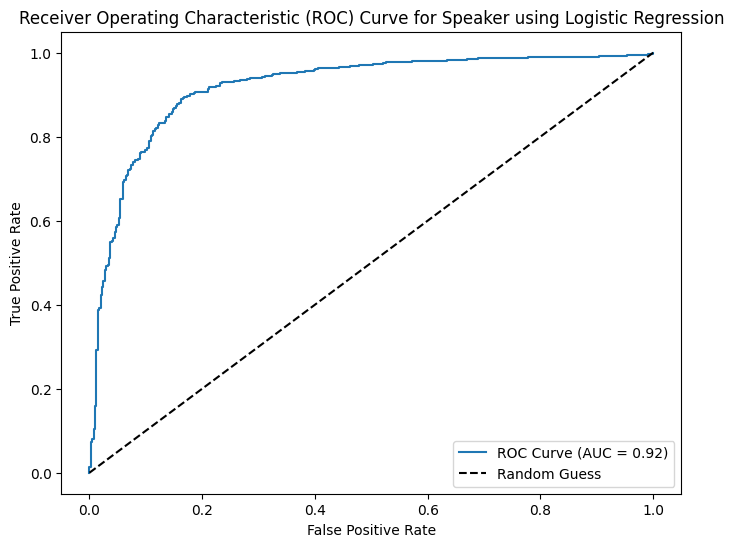

In [49]:
# Speaker Classification using Logistic Regression
# 1. Train logistic regression from scratch
learning_rate = 0.001
num_iterations = 10000
w, b = train_logistic_regression(X, y_speaker, learning_rate, num_iterations)

# 2. Compute binary predictions (for confusion matrix, accuracy, etc.)
predictions = predict_logistic_regression(X, w, b, threshold=0.5)

accuracy = np.mean(predictions == y_speaker) * 100
print(f"\nTraining Accuracy: {accuracy:.2f}%")

print("\nClassification Report:")
print(classification_report(y_speaker, predictions))

conf_mat = confusion_matrix(y_speaker, predictions)
print("Confusion Matrix:")
print(conf_mat)

precision = precision_score(y_speaker, predictions)
recall = recall_score(y_speaker, predictions)
f1 = f1_score(y_speaker, predictions)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# 3. Get continuous probabilities for ROC/AUC
probabilities = predict_proba_logistic_regression(X, w, b)

auc_score = roc_auc_score(y_speaker, probabilities)
print(f"AUC: {auc_score:.2f}")

# 4. Plot the ROC curve
fpr, tpr, _ = roc_curve(y_speaker, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Speaker using Logistic Regression")
plt.legend(loc="lower right")
plt.show()


Iteration 0, Cost: 0.6931
Iteration 1000, Cost: 0.3183
Iteration 2000, Cost: 0.3074
Iteration 3000, Cost: 0.3029
Iteration 4000, Cost: 0.3007
Iteration 5000, Cost: 0.2994
Iteration 6000, Cost: 0.2987
Iteration 7000, Cost: 0.2983
Iteration 8000, Cost: 0.2980
Iteration 9000, Cost: 0.2979

Training Accuracy: 88.94%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       434
           1       0.87      0.89      0.88       389

    accuracy                           0.89       823
   macro avg       0.89      0.89      0.89       823
weighted avg       0.89      0.89      0.89       823

Confusion Matrix:
[[384  50]
 [ 41 348]]
Precision: 0.87
Recall: 0.89
F1 Score: 0.88
AUC: 0.95


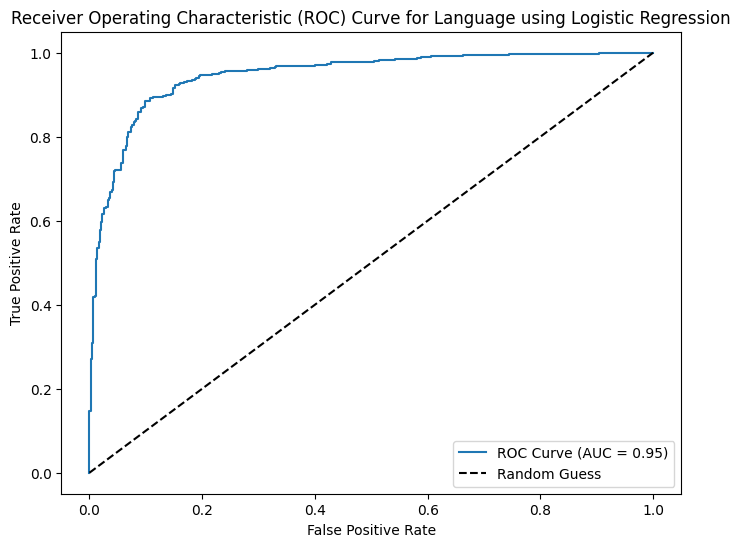

In [50]:
# Classifying for Language Label

# 1. Train logistic regression from scratch
learning_rate = 0.001 # I brute-forced learning rate and this seems to qork quite well for this classification. It's not the best though.
num_iterations = 10000
w, b = train_logistic_regression(X, y_language, learning_rate, num_iterations)

# 2. Compute binary predictions (for confusion matrix, accuracy, etc.)
predictions = predict_logistic_regression(X, w, b, threshold=0.5)

accuracy = np.mean(predictions == y_language) * 100
print(f"\nTraining Accuracy: {accuracy:.2f}%")

print("\nClassification Report:")
print(classification_report(y_language, predictions))

conf_mat = confusion_matrix(y_language, predictions)
print("Confusion Matrix:")
print(conf_mat)

precision = precision_score(y_language, predictions)
recall = recall_score(y_language, predictions)
f1 = f1_score(y_language, predictions)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# 3. Get continuous probabilities for ROC/AUC
probabilities = predict_proba_logistic_regression(X, w, b)

auc_score = roc_auc_score(y_language, probabilities)
print(f"AUC: {auc_score:.2f}")

# 4. Plot the ROC curve
fpr, tpr, _ = roc_curve(y_language, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Language using Logistic Regression")
plt.legend(loc="lower right")
plt.show()


## Plotting Decision boundary 
#### Using PCA and two components for ease of visualization

In [51]:
def plot_pca_decision_boundary(X, y, w, b, n_components=2, comp_x=0, comp_y=1, 
                               figsize=(8, 6), label_type="Language (1=English, 0=Not English)",
                               title="Decision Boundary (PCA)"):
    """
    Uses PCA to reduce the features in X to 2 dimensions, plots the data points colored by y, and overlays
    the decision boundary of the logistic regression model trained on the original X.
    
    Parameters:
      X : numpy array of shape (m, n)
          Original feature matrix.
      y : numpy array of shape (m,)
          Binary labels (0 or 1).
      w : numpy array of shape (n, 1)
          Logistic regression weights (trained on X).
      b : float
          Logistic regression bias.
      n_components : int, default=2
          Number of PCA components.
      comp_x, comp_y : int, default=0,1
          Indices of the PCA components to plot on the x- and y-axes.
      figsize : tuple, default=(8,6)
          Figure size.
      label_type : str
          Descriptive label for the color bar (e.g. "Language (1=English, 0=Not English)").
      title : str
          Title for the plot.
    """
    # Fit PCA on the original features X
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=figsize)
    # Plot the data points in the reduced space, colored by y
    scatter = plt.scatter(X_reduced[:, comp_x], X_reduced[:, comp_y], c=y, cmap='viridis', alpha=0.7)
    plt.xlabel(f"Principal Component {comp_x+1}")
    plt.ylabel(f"Principal Component {comp_y+1}")
    plt.title(title)
    cbar = plt.colorbar(scatter)
    cbar.set_label(label_type)  # More descriptive color bar label
    
    # Compute the effective weights in PCA space
    w_reduced = pca.components_.dot(w)  # shape: (n_components, 1)
    
    # Generate a range of values for the x-axis (first principal component)
    x_min, x_max = X_reduced[:, comp_x].min(), X_reduced[:, comp_x].max()
    x_vals = np.linspace(x_min, x_max, 200)
    
    # Solve for y-axis in PCA space: w_reduced[0]*z0 + w_reduced[1]*z1 + b = 0
    # => z1 = -(w_reduced[0]*z0 + b) / w_reduced[1]
    y_vals = -(w_reduced[comp_x]*x_vals + b) / w_reduced[comp_y]
    
    # Plot the decision boundary
    plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Decision Boundary')
    plt.legend()
    plt.tight_layout()
    plt.show()


Iteration 0, Cost: 0.6931
Iteration 1000, Cost: 0.3183
Iteration 2000, Cost: 0.3074
Iteration 3000, Cost: 0.3029
Iteration 4000, Cost: 0.3007
Iteration 5000, Cost: 0.2994
Iteration 6000, Cost: 0.2987
Iteration 7000, Cost: 0.2983
Iteration 8000, Cost: 0.2980
Iteration 9000, Cost: 0.2979

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       434
           1       0.87      0.89      0.88       389

    accuracy                           0.89       823
   macro avg       0.89      0.89      0.89       823
weighted avg       0.89      0.89      0.89       823



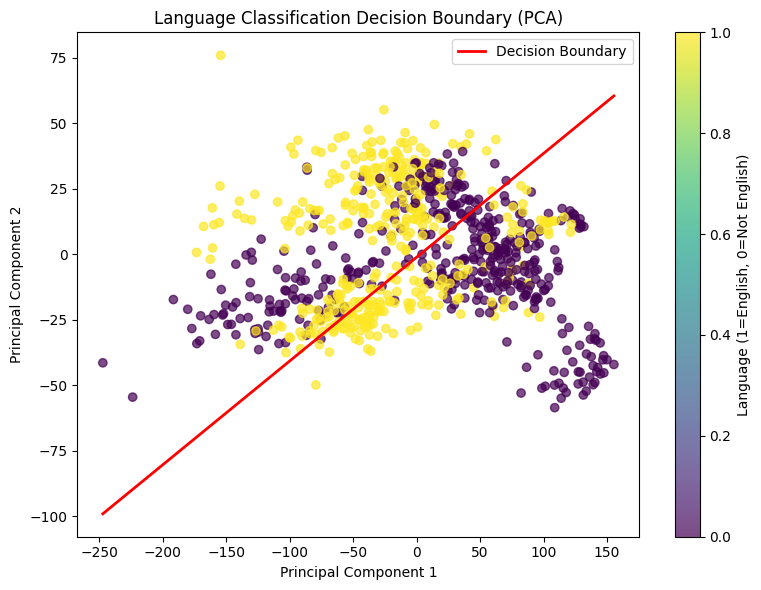

In [52]:
# For language labels:
learning_rate = 0.001
num_iterations = 10000
w, b = train_logistic_regression(X, y_language, learning_rate, num_iterations)

# 2. Get the predictions (0/1) for your training data
predictions = predict_logistic_regression(X, w, b, threshold=0.5)

# 3. Print classification metrics
print("\nClassification Report:")
print(classification_report(y_language, predictions))

plot_pca_decision_boundary(
    X, y_language, w, b, 
    n_components=2, comp_x=0, comp_y=1, 
    label_type="Language (1=English, 0=Not English)",
    title="Language Classification Decision Boundary (PCA)"
)

It's not classified well enough with two principal components as seen in the graph, but using all 13 components would help (or perhaps overfit if cross validation is not used).

# Mathematical Explanation for other models

### 1. Feature Extraction: MFCC Averaging

For each audio file, we extract Mel Frequency Cepstral Coefficients (MFCCs) which provide a compact representation of the audio's spectral properties.

- **MFCC Extraction:**  
  The audio signal is first transformed into the frequency domain using a Short-Time Fourier Transform (STFT). The resulting spectrogram is mapped to the Mel scale (a perceptually motivated frequency scale), and then a Discrete Cosine Transform (DCT) is applied to decorrelate the coefficients.

- **Averaging MFCCs:**  
  Let $ \text{MFCC}(i, t) $ be the $ i $-th MFCC coefficient at time frame $ t $. The function computes the mean value of each coefficient across all $ T $ time frames:

  $$ 
  \text{MFCC}_\text{mean}(i) = \frac{1}{T} \sum_{t=1}^{T} \text{MFCC}(i, t)
  $$

  This averaged vector serves as a fixed-length feature representation of the audio file.

## 2. Dataset Construction and Labeling

The dataset is built by reading a metadata CSV file containing at least the columns: `filename`, `speaker_label`, and `language_label`. For each audio file:

- **Feature Vector ($ X $)**:  
  The averaged MFCC vector obtained from the audio file.

- **Binary Labels:**  
  Two binary labels are created:
  - **Speaker Label ($ y_{\text{speaker}} $)**:

    $$
    y_{\text{speaker}} = 
    \begin{cases}
    1, & \text{if the speaker is "Jeevan"} \\
    0, & \text{otherwise}
    \end{cases}
    $$

  - **Language Label ($ y_{\text{language}} $)**:

    $$
    y_{\text{language}} = 
    \begin{cases}
    1, & \text{if the language is "English"} \\
    0, & \text{otherwise}
    \end{cases}
    $$

## 3. K-Fold Cross Validation


- **Data Splitting:**  
  The dataset is split into $ K $ folds (5 in our case). For each fold $ i $ (where $ i = 1, \dots, K $):

  - We train the model on $ K-1 $ folds.
  - And test on the remaining fold.

- **Performance Metrics:**  
  Let $ a_i $ be the performance (e.g., accuracy) on the $ i $-th fold. The overall performance is computed as:

  $$
  \text{Average Accuracy} = \frac{1}{K} \sum_{i=1}^{K} a_i
  $$

  and the standard deviation is:

  $$
  \sigma = \sqrt{\frac{1}{K} \sum_{i=1}^{K} \left(a_i - \text{Average Accuracy}\right)^2}
  $$


### 4.1 Support Vector Machine (SVM)
Used the following source to learn: https://www.geeksforgeeks.org/support-vector-machine-algorithm/, https://scikit-learn.org/stable/modules/svm.html

**Goal:** Find a hyperplane that maximizes the margin between two classes.  

1. **Linear SVM Decision Boundary:**

   $$
   w \cdot x + b = 0
   $$

   where $ w $ is the weight vector and $ b $ is a bias term.

2. **Hard-Margin Optimization (Linearly Separable Data):**  
   The SVM solves

   $$
   \min_{w, b} \;\; \frac{1}{2} \|w\|^2
   $$

   subject to

   $$
   y_i(w \cdot x_i + b) \ge 1 \quad \forall i,
   $$

   where $ y_i \in \{-1, +1\} $ are the class labels and $ x_i $ are feature vectors.

3. **Soft-Margin SVM (Realistic Case):**  
   Introduces slack variables $ \xi_i $ to allow some misclassifications:

   $$
   \min_{w, b, \xi} \;\; \frac{1}{2}\|w\|^2 + C \sum_{i=1}^N \xi_i
   $$

   subject to

   $$
   y_i(w \cdot x_i + b) \ge 1 - \xi_i, \quad \xi_i \ge 0.
   $$


### 4.2 Random Forest

**Goal:** Create diverse decision trees to reduce overfitting and improve predictive performance.

1. **Bootstrap Sampling:**  
   Each tree is trained on a **bootstrap sample** of the training data (sampling with replacement).

2. **Random Feature Subset:**  
   At each split in a tree, only a random subset of features is considered.

3. **Prediction Aggregation:**  
   The final prediction is made by majority vote across all trees:

   $$
   \hat{y} = \text{majority\_vote} \Bigl\{ T_1(x), T_2(x), \dots, T_m(x) \Bigr\},
   $$

   where $ T_j $ is the $ j $-th decision tree, and $ m $ is the number of trees in the forest.

## Recording and classifying a single audio

In [53]:
%gui tk

In [54]:
# Load Pre-Trained Models

speaker_model_path = "best_speaker_model.pkl"
language_model_path = "best_language_model.pkl"

speaker_model = joblib.load(speaker_model_path)
language_model = joblib.load(language_model_path)

# Label mappings for better readability
speaker_labels = {1: "Jeevan", 0: "Not Jeevan"}
language_labels = {1: "English", 0: "Not English"}

In [55]:
# Predict Single Audio

def extract_features(file_path, sr=16000, n_mfcc=13):
    """
    Loads an audio file, extracts MFCC features, and returns the averaged MFCCs.
    """
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def predict_single_audio(file_path):
    """
    Extracts features from a single audio file and predicts its speaker and language.
    
    Returns:
      (predicted_speaker_label, predicted_language_label)
    """
    features = extract_features(file_path)  
    features = features.reshape(1, -1)  # Reshape for model input

    # Predict Speaker
    speaker_pred = speaker_model.predict(features)[0]
    speaker_result = speaker_labels[speaker_pred]  # Convert to readable label

    # Predict Language
    language_pred = language_model.predict(features)[0]
    language_result = language_labels[language_pred]  # Convert to readable label

    return speaker_result, language_result

# Audio Recording Function (Tkinter UI)

def record_audio(duration=7, filename='temp.wav'):
    """
    Records audio from the microphone for 'duration' seconds and saves it as 'filename'.
    """
    chunk = 1024 
    format_ = pyaudio.paInt16
    channels = 1
    rate = 16000
    
    p = pyaudio.PyAudio()
    stream = p.open(format=format_, channels=channels, rate=rate, input=True, frames_per_buffer=chunk)
    
    frames = []
    for _ in range(int(rate / chunk * duration)):
        data = stream.read(chunk)
        frames.append(data)
    
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(format_))
    wf.setframerate(rate)
    wf.writeframes(b''.join(frames))
    wf.close()


# Classify and Update UI

def classify_audio():
    """
    Records an audio sample, classifies it using trained models,
    and updates the UI with the predicted labels.
    """
    record_audio(duration=7, filename='temp.wav')  # Record audio
    predicted_speaker, predicted_language = predict_single_audio('temp.wav')  # Get predictions
    
    # Update UI with results
    result_label.config(text=f"Predicted Speaker: {predicted_speaker}\nPredicted Language: {predicted_language}")


# Tkinter UI Setup

app = tk.Tk()
app.title("Audio Classifier")

record_button = tk.Button(app, text="Record & Classify", command=classify_audio)
record_button.pack(pady=10)

result_label = tk.Label(app, text="Result will appear here", font=("Helvetica", 14))
result_label.pack(pady=10)

app.mainloop()


can't invoke "event" command: application has been destroyed
    while executing
"event generate $w <<ThemeChanged>>"
    (procedure "ttk::ThemeChanged" line 6)
    invoked from within
"ttk::ThemeChanged"


The UI looks as follows:

<img src="Audio_classifier_UI.png" alt="Audio Classifier UI" width="500">

Video of a Live demo: https://youtu.be/GtHHAAfat14

Results: Accurately predicted speaker but Falsely predicted the language once in three trials.

# HC Footnotes

### **1. #dataviz**
I used #dataviz in various ways starting with visualizing my data (This was important as my data is not submittted as part of the assignment). The primary use was to compare all three models. I used PCA to reduce dimensionality and plot decision boundaries, ROC curves to assess classifier performance, and confusion matrices to understand classification errors. Visualizing my results helped me refine the models, debug issues, and communicate findings more clearly. 

### **2. #biasidentification**
I had to be mindful of **bias identification**, particularly in the dataset. Since my goal was to fine-tune a model with my own voice data, I recognized that overfitting could be a significant issue. I also ensured that classification models didn’t disproportionately favor certain labels due to imbalanced training data. After noticing the imbalanced training data, I collected more data, although I could have used techniques like sampliong the data or others (https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html). This choice was made as more data collection now means an easier 2nd assignment.

### **3. #optimization**
I applied optimization techniques to improve both model performance and computational efficiency. For hyperparameter tuning, I used Grid Search and Random Search (most of the times) to find the best settings for my Random Forest and Logistic Regression models. In training logistic regression, I optimized the learning rate $alpha$ to balance convergence speed and stability. I also experimented with feature selection, testing different subsets of MFCCs to retain only the most relevant information for classification. Additionally, I optimized the MFCC extraction process by averaging over time, reducing feature dimensionality while preserving key spectral characteristics.

#### AI Statement:
I extensively used LLMs for various things. The primary LLM I used was OpenAI's GPT 4o. I used the voice chat mode to discuss my idea and ask for suggestions. While it's needs repeatitive prompting, and isn't very technical, it does know the resources to use. I used these tools and the official documentation of scikit-learn side by side to solve all the bugs I got. My format would be; Ask GPT how to do something --. it points to a spoecific part of the library and gives link to the documentation --> I go to the documentation, review and then correct my bugs.
Furthermore, I used libraries like Librosa and some other resources and the links to the specific sites are attached in text.

# Appendix:
While most code is in this PDF (notebook), the preprocessing and data extraction code is in Github as .py files. It can be found in the Repo: https://github.com/lifee77/voice-classification
The code is pasted here for easy reference:

In [ ]:
# audio_preprocessing.py

import os
import numpy as np
import librosa
import soundfile as sf
from pydub import AudioSegment

def convert_m4a_to_mp3(file_path):
    """
    Converts an .mp4a audio file to .mp3 format using pydub.
    
    Parameters:
        file_path (str): Path to the input .mp4a file.
    
    Returns:
        str: File path of the converted .mp3 file.
    """
    # Load the .mp4a file using the correct format ("m4a"). Ensure that ffmpeg is installed.
    audio = AudioSegment.from_file(file_path, format="m4a")
    # Create a new file path with the .mp3 extension
    mp3_file_path = os.path.splitext(file_path)[0] + ".mp3"
    # Export the audio in mp3 format
    audio.export(mp3_file_path, format="mp3")
    print(f"Converted {file_path} to {mp3_file_path}")
    return mp3_file_path

def remove_silence(audio, sr, top_db=20):
    """
    Removes silence from the beginning and end of an audio signal.

    Parameters:
        audio (np.ndarray): Audio waveform.
        sr (int): Sampling rate.
        top_db (int): The threshold (in decibels) below the reference to consider as silence.

    Returns:
        np.ndarray: Audio waveform with beginning and ending silence removed.
    """
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db)
    return trimmed_audio

def remove_long_silence(audio, sr, top_db=20, gap_threshold=2.0):
    """
    Removes silence (or very low energy segments) from the center of an audio if they are longer than gap_threshold seconds.

    This function uses librosa.effects.split() to detect non-silent intervals.
    If the gap between two non-silent intervals is longer than the gap_threshold (in seconds),
    the gap is removed (i.e., the segments are concatenated).

    Parameters:
        audio (np.ndarray): Audio waveform.
        sr (int): Sampling rate.
        top_db (int): Threshold (in decibels) for silence detection.
        gap_threshold (float): Duration (in seconds) of silence to remove from the center.

    Returns:
        np.ndarray: Audio waveform with long silences removed.
    """
    # Get non-silent intervals (each as [start, end] in samples)
    intervals = librosa.effects.split(audio, top_db=top_db)
    if len(intervals) == 0:
        return audio  # Return original if no non-silent parts are found

    output_audio = []
    # Always include the first non-silent interval
    output_audio.append(audio[intervals[0][0]:intervals[0][1]])
    
    # Iterate over subsequent intervals
    for i in range(1, len(intervals)):
        prev_end = intervals[i-1][1]
        current_start = intervals[i][0]
        gap_duration = (current_start - prev_end) / sr
        if gap_duration < gap_threshold:
            # If the silence is short, include it.
            output_audio.append(audio[prev_end:current_start])
        # Otherwise, skip the gap.
        output_audio.append(audio[intervals[i][0]:intervals[i][1]])
    
    return np.concatenate(output_audio)

def normalize_audio(audio):
    """
    Normalizes the audio signal to have zero mean and unit variance.

    Parameters:
        audio (np.ndarray): Audio waveform.

    Returns:
        np.ndarray: Normalized audio waveform.
    """
    mean = np.mean(audio)
    std = np.std(audio)
    if std > 0:
        normalized_audio = (audio - mean) / std
    else:
        normalized_audio = audio - mean
    return normalized_audio

def pad_audio(audio, target_length, sr):
    """
    Pads the audio signal with zeros to reach the target length (in seconds).

    Parameters:
        audio (np.ndarray): Audio waveform.
        target_length (int): Target length in seconds.
        sr (int): Sampling rate.

    Returns:
        np.ndarray: Padded audio waveform.
    """
    target_samples = target_length * sr
    if len(audio) < target_samples:
        padded_audio = np.pad(audio, (0, target_samples - len(audio)), mode='constant')
    else:
        padded_audio = audio
    return padded_audio

def split_audio(audio, sr, split_length=7):
    """
    Splits the audio into multiple segments of fixed length.

    Parameters:
        audio (np.ndarray): Audio waveform.
        sr (int): Sampling rate.
        split_length (int): Desired segment length in seconds.

    Returns:
        list of np.ndarray: List of audio segments.
    """
    num_samples_per_segment = split_length * sr
    total_samples = len(audio)
    segments = []
    for start in range(0, total_samples, num_samples_per_segment):
        end = start + num_samples_per_segment
        segment = audio[start:end]
        # Option: Only add segments that are exactly split_length long.
        # Alternatively, you could pad the last segment.
        if len(segment) == num_samples_per_segment:
            segments.append(segment)
    return segments

def process_audio_file(file_path, output_directory, sr=16000, split_length=7, top_db=20, gap_threshold=2.0):
    """
    Processes an audio file by removing silence, normalizing, optionally removing long internal silences,
    and splitting it into segments. Saves each segment as a separate WAV file in output_directory.

    Parameters:
        file_path (str): Path to the input audio file.
        output_directory (str): Directory to save the processed audio segments.
        sr (int): Sampling rate.
        split_length (int): Length (in seconds) of each segment.
        top_db (int): Threshold for silence removal.
        gap_threshold (float): Duration (in seconds) of silence in the center to remove.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Load audio
    audio, sr = librosa.load(file_path, sr=sr)
    
    # Remove silence from beginning and end
    audio = remove_silence(audio, sr, top_db=top_db)
    
    # Remove long silence from the center (if gap > gap_threshold seconds)
    audio = remove_long_silence(audio, sr, top_db=top_db, gap_threshold=gap_threshold)
    
    # Normalize audio
    audio = normalize_audio(audio)
    
    # Split audio into segments of fixed length
    segments = split_audio(audio, sr, split_length=split_length)
    
    # Save segments
    base_filename = os.path.splitext(os.path.basename(file_path))[0]
    for i, segment in enumerate(segments):
        output_file = os.path.join(output_directory, f"{base_filename}_segment_{i+1}.wav")
        sf.write(output_file, segment, sr)
        print(f"Saved: {output_file}")

def process_directory(input_directory, output_directory, sr=16000, split_length=7, top_db=20, gap_threshold=2.0):
    """
    Processes all WAV audio files in the input_directory by applying pre-processing and splitting.
    Saves all processed segments in output_directory.

    Parameters:
        input_directory (str): Directory containing the input audio files.
        output_directory (str): Directory to save processed audio segments.
        sr (int): Sampling rate.
        split_length (int): Length (in seconds) of each segment.
        top_db (int): Threshold for silence removal.
        gap_threshold (float): Duration (in seconds) of silence in the center to remove.
    """
    for filename in os.listdir(input_directory):
        if filename.lower().endswith(('.mp3', '.m4a')):
            file_path = os.path.join(input_directory, filename)
            # If the file is a .m4a, convert it to .mp3 before processing.
            if filename.lower().endswith('.m4a'):
                file_path = convert_m4a_to_mp3(file_path)
            print(f"Processing file: {file_path}")
            process_audio_file(file_path, output_directory, sr=sr, split_length=split_length, top_db=top_db, gap_threshold=gap_threshold)

# Additional audio pre-processing functions can be added here
# For example, noise reduction, bandpass filtering, or data augmentation functions.

if __name__ == "__main__":
    # Example usage:
    # Specify the input directory containing your raw audio files
    input_dir = "data/raw_audio"  # Change this to your input audio directory
    # Specify the output directory where processed segments will be saved
    output_dir = "data/audio_data"  # This directory will be created if it does not exist
    
    process_directory(input_dir, output_dir)

In [ ]:
#automate_metadata.py

import os
import csv

# Set the directory to search for audio files
input_directory = "data/audio_data"  # Change this to your directory if needed

# Set the output CSV filename
output_csv = "metadata.csv"

# List all files in the input directory and filter for .wav files, then sort them alphabetically
filenames = sorted([f for f in os.listdir(input_directory) if f.lower().endswith('.wav')])

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write the header
    writer.writerow(["filename", "speaker_label", "language_label"])
    
    # Write each file's metadata with default values
    for filename in filenames:
        writer.writerow([filename, "Not_Jeevan", "Not_English"])

print(f"Metadata saved to {output_csv}")

In [ ]:
#video_to_audio.py

import os
import subprocess

def extract_audio_ffmpeg(input_folder, output_folder, video_extensions=('.mp4', '.avi', '.mov', '.mkv')):
    """
    Extracts audio from all video files in the input folder using FFmpeg and saves them as MP3 files in the output folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        if file_name.lower().endswith(video_extensions):
            video_path = os.path.join(input_folder, file_name)
            output_file_name = os.path.splitext(file_name)[0] + '.mp3'
            audio_path = os.path.join(output_folder, output_file_name)
            
            try:
                print(f"Processing {file_name} with FFmpeg...")
                # The command below extracts the audio stream and saves it as MP3.
                command = [
                    "ffmpeg", "-i", video_path, "-vn", "-ab", "128k", "-ar", "44100", "-y", audio_path
                ]
                subprocess.run(command, check=True)
                print(f"Saved audio to {audio_path}")
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

# Example usage:
extract_audio_ffmpeg('data/video_data', 'data/raw_audio')

In [ ]:
#youtube_to_audio.py

import os
import yt_dlp

def download_youtube_audio(url, output_path="data/raw_audio", output_filename="youtube_audio.mp3"):
    """
    Downloads the audio from a YouTube video and converts it to MP3 using yt-dlp.

    Parameters:
        url (str): URL of the YouTube video.
        output_path (str): Directory where the MP3 file will be saved.
        output_filename (str): Desired filename for the output MP3 file.

    Returns:
        None
    """
    # Ensure the output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Set up yt-dlp options to extract audio and convert to mp3
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': os.path.join(output_path, output_filename),
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
        # Uncomment the next line if you encounter SSL issues:
        # 'nocheckcertificate': True,
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        print("Downloading and converting audio...")
        ydl.download([url])
    print(f"Audio saved as: {os.path.join(output_path, output_filename)}")

if __name__ == "__main__":
    # Example YouTube video URL
    youtube_url = "https://www.youtube.com/watch?v=Dw9-E8Gb4Nc"
    download_youtube_audio(youtube_url)